In [11]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [13]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
# Extract the ZIP file
def extract_dataset(zip_path, extract_path):
    """Extract the dataset from a ZIP file"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to {extract_path}")

In [15]:
# Function to explore the dataset and check for issues
def explore_dataset(data_dir):
    """Explore the dataset structure and count samples"""
    try:
        class_names = sorted(os.listdir(data_dir))
        class_names = [c for c in class_names if os.path.isdir(os.path.join(data_dir, c))]

        if not class_names:
            print(f"ERROR: No class directories found in {data_dir}")
            print(f"Contents of {data_dir}: {os.listdir(data_dir)}")
            return None, None

        print(f"Classes: {class_names}")

        total_samples = 0
        class_counts = {}

        for class_name in class_names:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))]
                count = len(files)
                class_counts[class_name] = count
                total_samples += count
                print(f"Class {class_name}: {count} images")

                # Check first few images to ensure they can be loaded
                for img_file in files[:3]:
                    try:
                        img_path = os.path.join(class_dir, img_file)
                        img = load_img(img_path)
                        arr = img_to_array(img)
                        print(f"  Sample image shape: {arr.shape}, min: {arr.min()}, max: {arr.max()}")
                    except Exception as e:
                        print(f"  ERROR loading {img_path}: {str(e)}")

        print(f"Total samples: {total_samples}")

        # Check class balance
        if len(class_counts) > 1:
            min_count = min(class_counts.values())
            max_count = max(class_counts.values())
            imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
            print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

            if imbalance_ratio > 1.5:
                print("WARNING: Significant class imbalance detected. Consider class weights or balancing techniques.")

        return class_names, class_counts
    except Exception as e:
        print(f"Error exploring dataset: {str(e)}")
        return None, None

In [16]:
# Function to visualize sample images with improved error handling
def visualize_samples(data_dir, class_names, samples_per_class=3):
    """Visualize sample images from each class"""
    plt.figure(figsize=(12, 5))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))][:samples_per_class]

        for j, img_file in enumerate(image_files):
            try:
                img_path = os.path.join(class_dir, img_file)
                img = plt.imread(img_path)

                # Detect if image is grayscale but has 3 channels (all identical)
                if img.ndim == 3 and img.shape[2] == 3:
                    # Check if all channels are identical (grayscale saved as RGB)
                    if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
                        print(f"Image {img_path} appears to be grayscale saved as RGB")

                plt.subplot(len(class_names), samples_per_class, i*samples_per_class + j + 1)

                # Use correct colormap depending on image dimensions
                if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
                    plt.imshow(img, cmap='gray')
                else:
                    plt.imshow(img)

                plt.title(f"{class_name}\n{img.shape}" if j == 0 else f"{img.shape}")
                plt.axis('off')

            except Exception as e:
                print(f"Error visualizing {img_file}: {str(e)}")

    plt.tight_layout()
    plt.show()

In [17]:
# Function to create a more suitable model for medical imaging
def create_model(input_shape=(224, 224, 3), use_grayscale=False):
    """Create a transfer learning model using DenseNet121 which works well for medical imaging"""
    # Adjust input shape for grayscale if needed
    if use_grayscale:
        input_shape = (input_shape[0], input_shape[1], 1)

    # Load the pre-trained model - DenseNet121 often performs well on medical images
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape if not use_grayscale else (input_shape[0], input_shape[1], 3)
    )

    # Create new model
    model = Sequential([
        # If using grayscale, we need to convert 1 channel to 3 channels
        tf.keras.layers.Conv2D(3, (1, 1), input_shape=input_shape) if use_grayscale else tf.keras.layers.InputLayer(input_shape=input_shape),
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),  # Increased dropout to prevent overfitting
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Freeze the base model layers
    base_model.trainable = False

    # Compile the model with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    return model

In [18]:
# Function to plot training history
def plot_training_history(history):
    """Plot the training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)

    # Plot training & validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

In [19]:
# Function to evaluate the model and visualize results
def evaluate_model(model, test_generator, class_names):
    """Evaluate model performance and visualize results"""
    # Reset the test generator
    test_generator.reset()

    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype("int32")

    # Get true labels
    y_true = test_generator.classes

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [20]:
# Main execution
def main():
    # Set random seed for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)

    # Set paths - you'll need to specify the zip file name after upload
    zip_path = '/content/Binary.zip'  # Update this with your actual zip file name
    extract_path = '/content'
    train_dir = os.path.join(extract_path, 'Binary/train')

    # Extract dataset
    print("Extracting dataset...")
    extract_dataset(zip_path, extract_path)

    # Verify dataset structure
    print("\nVerifying dataset structure:")
    print(f"Extract path contents: {os.listdir(extract_path)}")

    if not os.path.exists(train_dir):
        # Try to find the correct path
        possible_train_dirs = [d for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
        if possible_train_dirs:
            print(f"Train directory not found at expected path, but found these directories: {possible_train_dirs}")
            train_dir = os.path.join(extract_path, possible_train_dirs[0])
            print(f"Using {train_dir} as training directory")
        else:
            print("ERROR: Could not locate training directory")
            return

    # Explore dataset
    print("\nExploring dataset...")
    class_names, class_counts = explore_dataset(train_dir)

    if not class_names:
        print("ERROR: Could not properly identify classes. Please check dataset structure.")
        return

    # Detect if images are grayscale (MRI images usually are)
    # Let's check a few images to determine
    use_grayscale = False
    sample_class = class_names[0]
    sample_dir = os.path.join(train_dir, sample_class)
    sample_images = [f for f in os.listdir(sample_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))]

    if sample_images:
        sample_img_path = os.path.join(sample_dir, sample_images[0])
        img = load_img(sample_img_path)
        img_arr = img_to_array(img)

        # Check if the image is grayscale (or if RGB channels are identical)
        if img_arr.shape[2] == 1 or (img_arr.shape[2] == 3 and
                                    np.allclose(img_arr[:,:,0], img_arr[:,:,1]) and
                                    np.allclose(img_arr[:,:,1], img_arr[:,:,2])):
            use_grayscale = True
            print("Detected grayscale images, will configure model accordingly")

    # Visualize samples
    print("\nVisualizing sample images...")
    visualize_samples(train_dir, class_names)

    # Calculate class weights to handle imbalance
    class_weights = None
    if len(class_counts) > 1:
        total = sum(class_counts.values())
        class_weights = {
            idx: total / (len(class_counts) * count)
            for idx, count in enumerate(class_counts.values())
        }
        print(f"Class weights to handle imbalance: {class_weights}")

    # Data augmentation for training - tailored for medical imaging
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,  # Less aggressive rotation for medical images
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,  # Usually not appropriate for medical images
        fill_mode='nearest',
        validation_split=0.2  # 20% for validation
    )

    # Test data generator (only rescaling, no augmentation)
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # 20% for validation
    )

    # Image dimensions
    img_height, img_width = 224, 224
    batch_size = 16  # Smaller batch size to improve generalization

    # Color mode based on detection
    color_mode = 'grayscale' if use_grayscale else 'rgb'

    # Create train generator with debug info
    print(f"\nCreating training generator with color_mode={color_mode}...")
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        color_mode=color_mode,
        shuffle=True
    )

    # Create validation generator
    validation_generator = test_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        color_mode=color_mode,
        shuffle=False
    )

    # Print class indices
    print("\nClass indices:", train_generator.class_indices)

    # Check a batch of data to verify shapes and values
    x_batch, y_batch = next(train_generator)
    print(f"Batch shape: {x_batch.shape}, Labels shape: {y_batch.shape}")
    print(f"First few labels: {y_batch[:5]}")
    print(f"Input range: min={x_batch.min()}, max={x_batch.max()}")

    # Create the model
    print("\nCreating model...")
    input_shape = (img_height, img_width, 1 if use_grayscale else 3)
    model = create_model(input_shape=input_shape, use_grayscale=use_grayscale)
    model.summary()

    # Callbacks for training
    checkpoint = ModelCheckpoint(
        'alzheimers_model_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,  # More patience since medical imaging may take longer to converge
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Train the model
    print("\nTraining the model...")
    epochs = 50  # Increase epochs but rely on early stopping

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[checkpoint, early_stopping, reduce_lr],
        class_weight=class_weights
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate the model
    print("\nEvaluating the model...")
    evaluate_model(model, validation_generator, list(train_generator.class_indices.keys()))

    # Save the final model
    model.save('alzheimers_classification_model.h5')
    print("\nModel saved as 'alzheimers_classification_model.h5'")

    # Fine-tuning: unfreeze some layers of the base model
    print("\nFine-tuning the model...")

    # Load the best model from checkpoint
    model.load_weights('alzheimers_model_best.h5')

    # Get the base model
    base_model = None
    for layer in model.layers:
        if hasattr(layer, 'layers'):  # This is likely our base model
            base_model = layer
            break

    if base_model:
        # Unfreeze the base model
        base_model.trainable = True

        # Freeze earlier layers and unfreeze later layers
        for layer in base_model.layers[:-30]:  # Keep more layers frozen
            layer.trainable = False

        print("Base model layers unfrozen for fine-tuning")
    else:
        print("Could not identify base model for fine-tuning")

    # Recompile with a much lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.00001),  # Very low learning rate for fine-tuning
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    # Train the model again
    history_fine_tune = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=20,  # Fewer epochs for fine-tuning
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[
            ModelCheckpoint('alzheimers_model_fine_tuned.h5', monitor='val_accuracy',
                           save_best_only=True, mode='max', verbose=1),
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
        ],
        class_weight=class_weights
    )

    # Plot fine-tuning history
    plot_training_history(history_fine_tune)

    # Evaluate the fine-tuned model
    print("\nEvaluating the fine-tuned model...")
    model.load_weights('alzheimers_model_fine_tuned.h5')  # Load the best fine-tuned model
    evaluate_model(model, validation_generator, list(train_generator.class_indices.keys()))

    print("\nFine-tuned model saved as 'alzheimers_model_fine_tuned.h5'")


Extracting dataset...
Dataset extracted to /content

Verifying dataset structure:
Extract path contents: ['.config', 'Binary.zip', 'alzheimers_model_best.h5', 'Binary', 'sample_data']

Exploring dataset...
Classes: ['Impairment', 'No Impairment']
Class Impairment: 2560 images
  Sample image shape: (128, 128, 3), min: 0.0, max: 254.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 248.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 252.0
Class No Impairment: 2560 images
  Sample image shape: (128, 128, 3), min: 0.0, max: 254.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 248.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 249.0
Total samples: 5120
Class imbalance ratio (max/min): 1.00
Detected grayscale images, will configure model accordingly

Visualizing sample images...


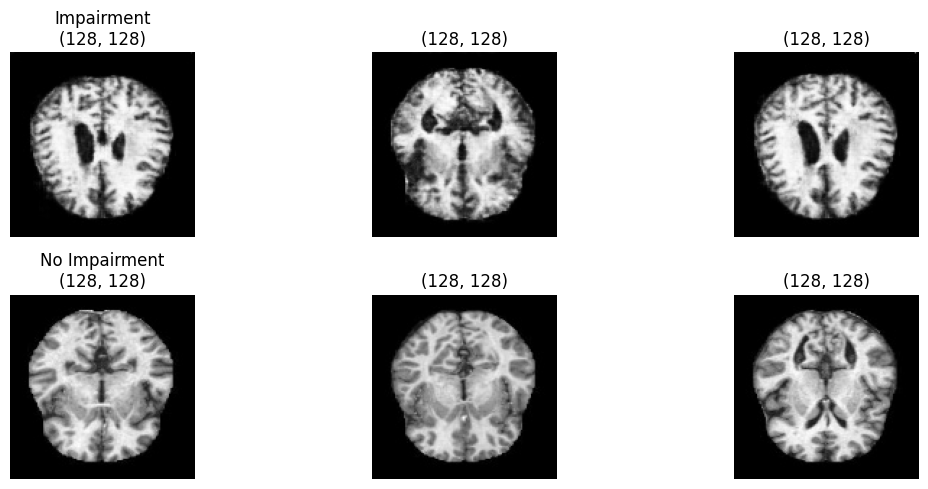

Class weights to handle imbalance: {0: 1.0, 1: 1.0}

Creating training generator with color_mode=grayscale...
Found 4096 images belonging to 2 classes.
Found 1024 images belonging to 2 classes.

Class indices: {'Impairment': 0, 'No Impairment': 1}
Batch shape: (16, 224, 224, 1), Labels shape: (16,)
First few labels: [0. 0. 1. 1. 0.]
Input range: min=0.0, max=1.0

Creating model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,634,759 (29.12 MB)

 Trainable params: 593,927 (2.27 MB)

 Non-trainable params: 7,040,832 (26.86 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Training the model...
Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8569 - auc: 0.9218 - loss: 0.3330
Epoch 1: val_accuracy improved from -inf to 0.96777, saving model to alzheimers_model_best.h5


256/256 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - accuracy: 0.8572 - auc: 0.9220 - loss: 0.3324 - val_accuracy: 0.9678 - val_auc: 0.9956 - val_loss: 0.1063 - learning_rate: 5.0000e-04
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9548 - auc: 0.9925 - loss: 0.1059
Epoch 2: val_accuracy improved from 0.96777 to 0.98340, saving model to alzheimers_model_best.h5


256/256 ━━━━━━━━━━━━━━━━━━━━ 44s 110ms/step - accuracy: 0.9549 - auc: 0.9925 - loss: 0.1059 - val_accuracy: 0.9834 - val_auc: 0.9993 - val_loss: 0.0481 - learning_rate: 5.0000e-04
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9671 - auc: 0.9948 - loss: 0.0900
Epoch 3: val_accuracy improved from 0.98340 to 0.99316, saving model to alzheimers_model_best.h5


256/256 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.9671 - auc: 0.9948 - loss: 0.0900 - val_accuracy: 0.9932 - val_auc: 0.9977 - val_loss: 0.0315 - learning_rate: 5.0000e-04
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9703 - auc: 0.9955 - loss: 0.0807
Epoch 4: val_accuracy improved from 0.99316 to 0.99512, saving model to alzheimers_model_best.h5


256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.9703 - auc: 0.9955 - loss: 0.0807 - val_accuracy: 0.9951 - val_auc: 0.9997 - val_loss: 0.0184 - learning_rate: 5.0000e-04
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9796 - auc: 0.9971 - loss: 0.0632
Epoch 5: val_accuracy did not improve from 0.99512
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.9796 - auc: 0.9971 - loss: 0.0633 - val_accuracy: 0.9922 - val_auc: 0.9990 - val_loss: 0.0267 - learning_rate: 5.0000e-04
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9737 - auc: 0.9967 - loss: 0.0703
Epoch 6: val_accuracy did not improve from 0.99512
256/256 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.9737 - auc: 0.9967 - loss: 0.0703 - val_accuracy: 0.9863 - val_auc: 0.9994 - val_loss: 0.0322 - learning_rate: 5.0000e-04
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9691 - auc: 0.9945 - loss: 0.0902
Epoch 7: val_accuracy did not improve from 0.99512
256/

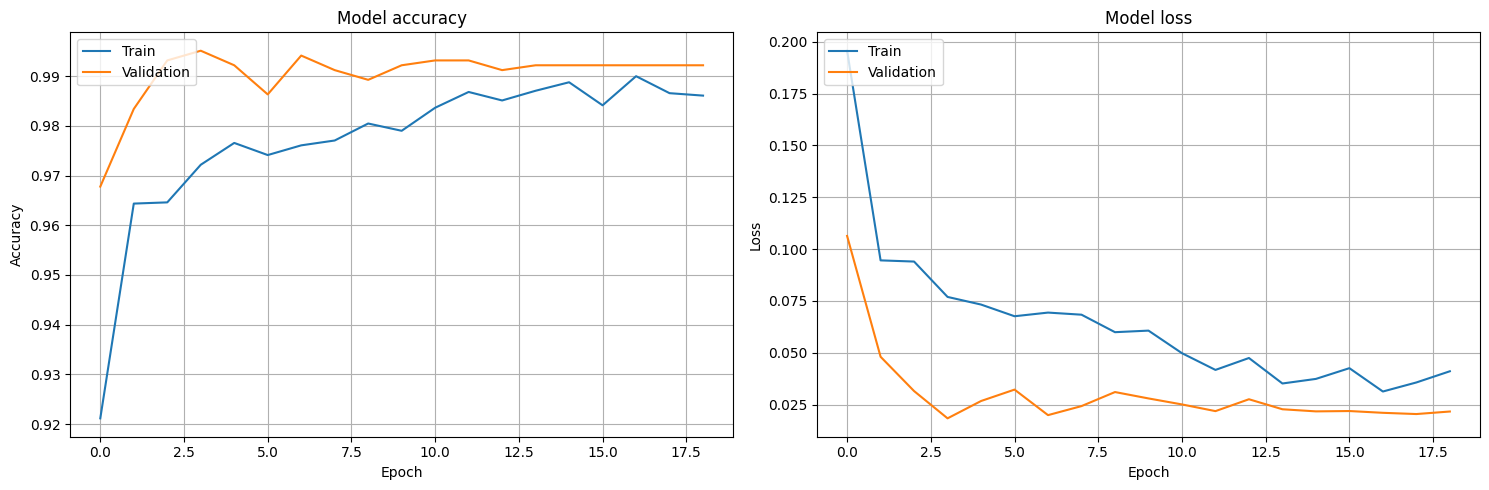

Final training accuracy: 0.9861
Final validation accuracy: 0.9922
Final training loss: 0.0411
Final validation loss: 0.0217

Evaluating the model...
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step


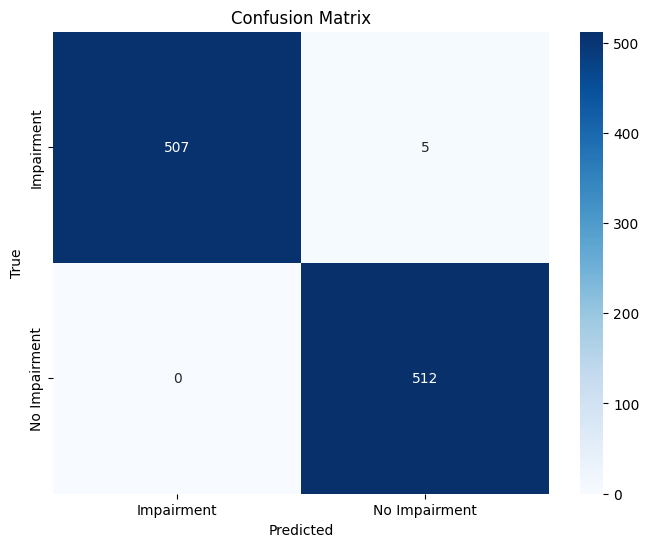


Classification Report:
               precision    recall  f1-score   support

   Impairment       1.00      0.99      1.00       512
No Impairment       0.99      1.00      1.00       512

     accuracy                           1.00      1024
    macro avg       1.00      1.00      1.00      1024
 weighted avg       1.00      1.00      1.00      1024



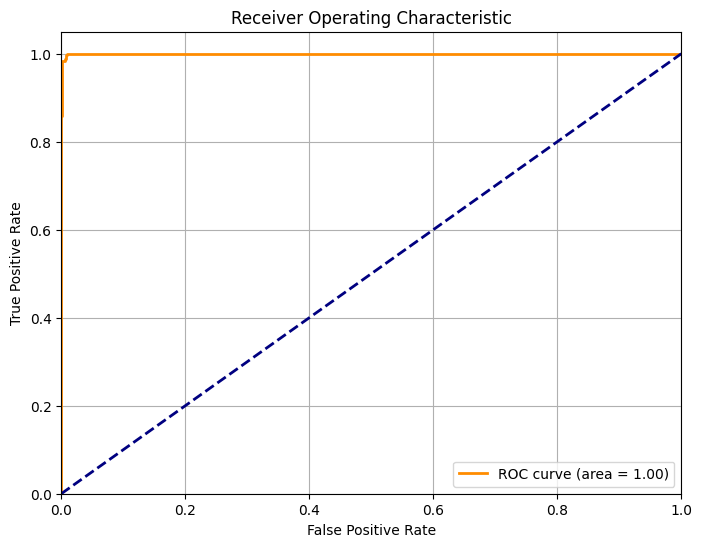


Model saved as 'alzheimers_classification_model.h5'

Fine-tuning the model...
Base model layers unfrozen for fine-tuning
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9707 - auc_1: 0.9966 - loss: 0.0746
Epoch 1: val_accuracy improved from -inf to 0.99316, saving model to alzheimers_model_fine_tuned.h5


256/256 ━━━━━━━━━━━━━━━━━━━━ 79s 154ms/step - accuracy: 0.9707 - auc_1: 0.9966 - loss: 0.0746 - val_accuracy: 0.9932 - val_auc_1: 0.9995 - val_loss: 0.0222 - learning_rate: 1.0000e-05
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9715 - auc_1: 0.9950 - loss: 0.0774
Epoch 2: val_accuracy improved from 0.99316 to 0.99512, saving model to alzheimers_model_fine_tuned.h5


256/256 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.9715 - auc_1: 0.9950 - loss: 0.0773 - val_accuracy: 0.9951 - val_auc_1: 0.9995 - val_loss: 0.0205 - learning_rate: 1.0000e-05
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9748 - auc_1: 0.9961 - loss: 0.0723
Epoch 3: val_accuracy did not improve from 0.99512
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.9748 - auc_1: 0.9961 - loss: 0.0723 - val_accuracy: 0.9951 - val_auc_1: 0.9995 - val_loss: 0.0200 - learning_rate: 1.0000e-05
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9768 - auc_1: 0.9966 - loss: 0.0671
Epoch 4: val_accuracy did not improve from 0.99512
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.9768 - auc_1: 0.9965 - loss: 0.0671 - val_accuracy: 0.9951 - val_auc_1: 0.9996 - val_loss: 0.0187 - learning_rate: 1.0000e-05
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9777 - auc_1: 0.9973 - loss: 0.0617
Epoch 5: val_accuracy did not improve

256/256 ━━━━━━━━━━━━━━━━━━━━ 42s 114ms/step - accuracy: 0.9843 - auc_1: 0.9985 - loss: 0.0428 - val_accuracy: 0.9971 - val_auc_1: 0.9999 - val_loss: 0.0103 - learning_rate: 1.0000e-05
Epoch 18/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9859 - auc_1: 0.9986 - loss: 0.0407
Epoch 18: val_accuracy did not improve from 0.99707
256/256 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.9859 - auc_1: 0.9986 - loss: 0.0407 - val_accuracy: 0.9951 - val_auc_1: 0.9999 - val_loss: 0.0125 - learning_rate: 1.0000e-05
Epoch 19/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9897 - auc_1: 0.9991 - loss: 0.0314
Epoch 19: val_accuracy did not improve from 0.99707
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.9897 - auc_1: 0.9991 - loss: 0.0315 - val_accuracy: 0.9951 - val_auc_1: 0.9999 - val_loss: 0.0123 - learning_rate: 1.0000e-05
Epoch 20/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9884 - auc_1: 0.9993 - loss: 0.0348
Epoch 20: val_accuracy did not 

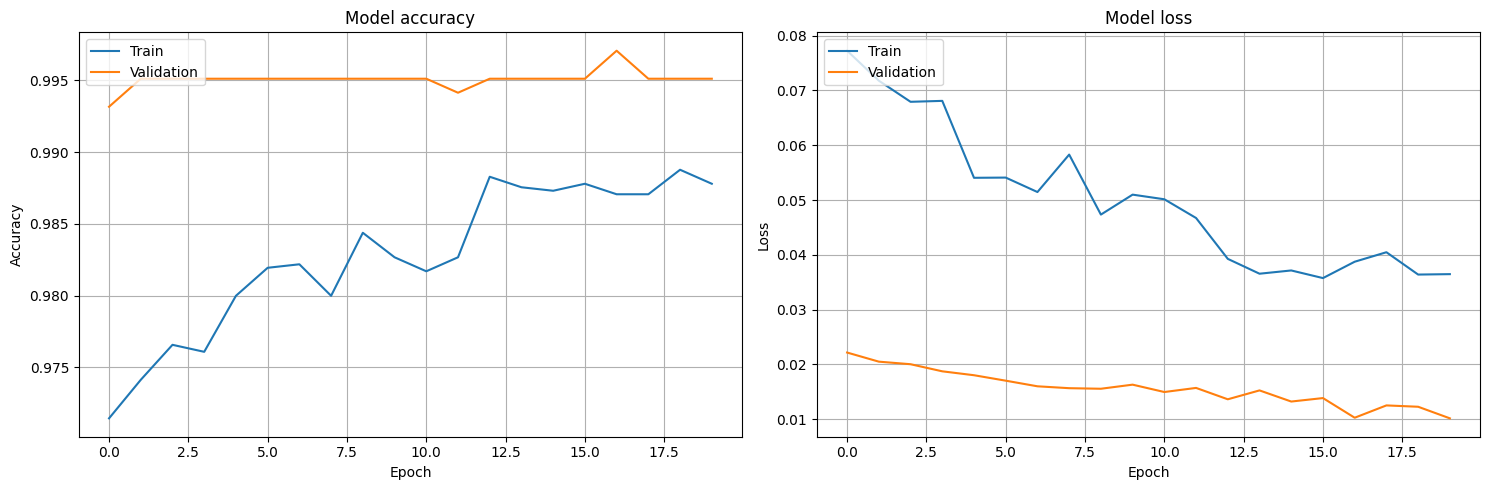

Final training accuracy: 0.9878
Final validation accuracy: 0.9951
Final training loss: 0.0365
Final validation loss: 0.0102

Evaluating the fine-tuned model...
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step


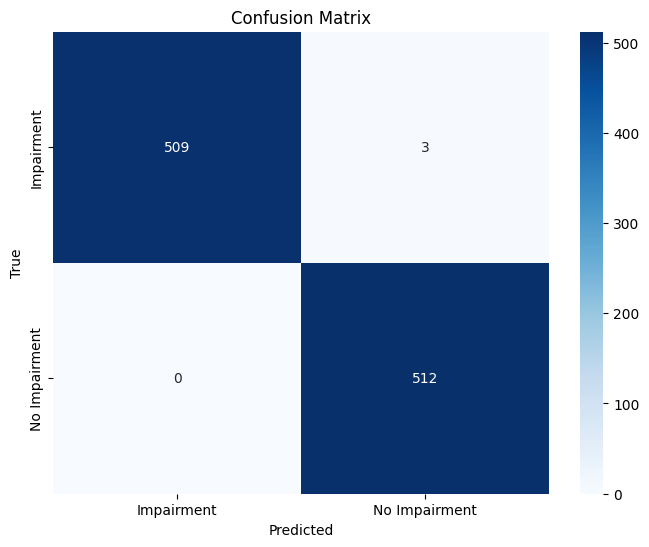


Classification Report:
               precision    recall  f1-score   support

   Impairment       1.00      0.99      1.00       512
No Impairment       0.99      1.00      1.00       512

     accuracy                           1.00      1024
    macro avg       1.00      1.00      1.00      1024
 weighted avg       1.00      1.00      1.00      1024



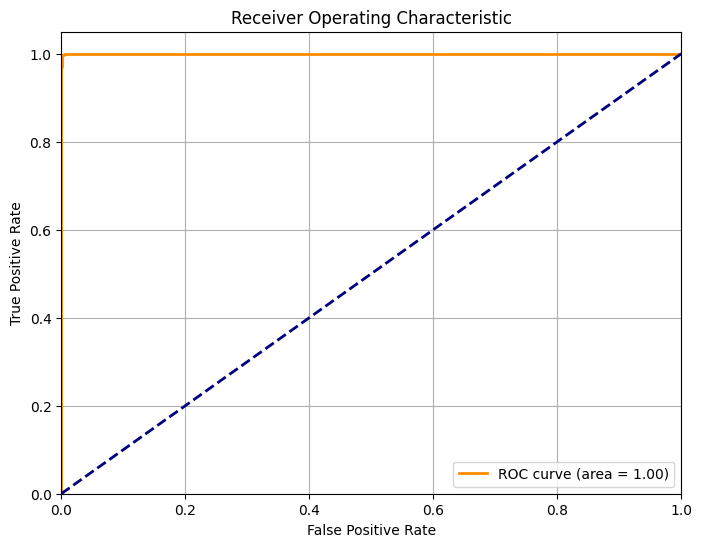


Fine-tuned model saved as 'alzheimers_model_fine_tuned.h5'


In [21]:
if __name__ == "__main__":
    main()